In [1]:
# Load selected variables from tensors.pkl and assign them with the same names
import os
import pickle
import numpy as np

FNAME = "tensors.pkl"
NEEDED_KEYS = ["mat_100pp_spikefiltered",
    "mat_100hp_spikefiltered",
    "lwhl",
    "speed",]

if not os.path.exists(FNAME):
    raise FileNotFoundError(f"File not found: {FNAME}")

with open(FNAME, "rb") as f:
    data = pickle.load(f)

if not isinstance(data, dict):
    raise ValueError("Pickle content is not a dict of named objects.")

# assign only needed keys for position modulation analysis (keep same variable names)
missing = []
for k in NEEDED_KEYS:
    if k in data:
        globals()[k] = data[k]
    else:
        globals()[k] = None
        missing.append(k)

def _brief(v):
    if isinstance(v, np.ndarray):
        return f"ndarray shape={v.shape}, dtype={v.dtype}"
    try:
        if hasattr(v, "shape") and v.shape is not None:
            return f"{type(v).__name__} shape={v.shape}"
        if hasattr(v, "__len__") and not isinstance(v, (str, bytes)):
            return f"{type(v).__name__} len={len(v)}"
    except Exception:
        pass
    return type(v).__name__

print(f"Loaded from {FNAME}:")
for k in NEEDED_KEYS:
    print(f"  • {k}: {_brief(globals()[k])}")

if missing:
    print("\n[warning] Missing key(s) in pickle:", ", ".join(missing))

Loaded from tensors.pkl:
  • mat_100pp_spikefiltered: ndarray shape=(399, 75707), dtype=float64
  • mat_100hp_spikefiltered: ndarray shape=(40, 75707), dtype=float64
  • lwhl: DataFrame shape=(295727, 7)
  • speed: ndarray shape=(295727,), dtype=float64


In [2]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
import pandas as pd
import logging
from typing import Optional, Iterable, Tuple, List, Dict, Any


def identify_position_modulated_neurons(
    activity_matrix: np.ndarray,              # (n_neurons, n_time_bins), spike COUNTS per bin (non-negative)
    bin_size_ms: float,                        # bin width in milliseconds
    lwhl: pd.DataFrame,                        # must contain 'linearized_pos_long' sampled at `sampling_rate_wheel`
    *,
    sampling_rate_wheel: float = 39.0625,      # Hz for lwhl index samples
    n_slices: int = 20,                        # number of position bins (slices)
    track_length_cm: float = 140.0,            # total linearized track length (used to slice positions)
    min_spikes: int = 100,                     # min total spikes per neuron AFTER optional speed filter
    alpha: float = 0.01,                       # target FDR level
    method: str = "fdr_bh",                    # correction method for multipletests
    use_nonparametric: bool = False,           # if True -> Kruskal–Wallis; else -> permutation on F-stat (recommended)
    verbose: bool = True,                      # info logging
    speed: Optional[np.ndarray] = None,        # optional 1-D speed (same length as lwhl, same sampling rate)
    speed_threshold: Optional[float] = None,   # keep bins with speed > threshold (if speed provided)
    min_bins_per_slice: int = 10,              # per-slice occupancy minimum to include it in stats
    n_perm: int = 1000,                        # number of circular-shift permutations (ignored if use_nonparametric)
    rng_seed: int = 0,                         # RNG seed for reproducibility
    top_k_plots: int = 8                       # how many top neurons (by p) to plot tuning mean±SEM
) -> Dict[str, Any]:
    """
    Identify neurons whose firing rates are significantly modulated by position (linearized track),
    and plot occupancy + per-slice tuning (mean±SEM) for the top-K most modulated neurons.

    IMPORTANT: No interpolation is performed anywhere in this function.

    Pipeline (no interpolation):
    1) Align linearized position (and optional speed) to bin centers via linear interpolation of signals
       onto bin times (this is alignment only, not filling missing slices).
    2) Optionally drop bins with speed <= threshold.
    3) Convert counts -> rates (Hz) with bin_size_ms.
    4) Discretize positions into n_slices over [0, track_length_cm).
    5) For each neuron:
       - Compute per-slice mean and SEM (ignoring NaNs, with SEM safe for n<=1).
       - Compute an observed F-statistic across slices with sufficient occupancy.
       - Get p-value via circular-shift permutation on the F-stat (or Kruskal–Wallis if requested).
       - Compute split-half reliability (even vs odd bins) on per-slice means (no interpolation).
    6) FDR-correct p-values and return results.
    7) Plots produced:
       - Occupancy per position slice (after any speed filter).
       - For the top-K neurons by p-value: bar (mean) + black error bars (SEM) across slices.

    Returns a dict with arrays, masks, p-values, correction, figures, and diagnostics.
    """

    # ---------- logger (non-invasive) ----------
    logger = logging.getLogger(__name__)
    if verbose and not logger.handlers:
        h = logging.StreamHandler()
        h.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
        logger.addHandler(h)
        logger.setLevel(logging.INFO)

    # ---------- validation ----------
    if not isinstance(activity_matrix, np.ndarray) or activity_matrix.ndim != 2:
        raise ValueError("activity_matrix must be 2D (n_neurons, n_time_bins).")
    if (activity_matrix < 0).any():
        raise ValueError("activity_matrix contains negative values (expected non-negative counts).")
    if np.isnan(activity_matrix).any():
        raise ValueError("activity_matrix contains NaNs; clean them first.")
    if not isinstance(lwhl, pd.DataFrame) or "linearized_pos_long" not in lwhl.columns:
        raise ValueError("lwhl must be a DataFrame with 'linearized_pos_long'.")
    if lwhl["linearized_pos_long"].isna().any():
        raise ValueError("lwhl['linearized_pos_long'] contains NaNs; clean them first.")
    if not (isinstance(bin_size_ms, (int, float)) and bin_size_ms > 0):
        raise ValueError("bin_size_ms must be > 0.")
    if not (isinstance(n_slices, int) and n_slices > 0):
        raise ValueError("n_slices must be a positive integer.")
    if not (0.0 < alpha < 1.0):
        raise ValueError("alpha must be in (0,1).")
    if not (isinstance(min_spikes, (int, np.integer)) and min_spikes >= 0):
        raise ValueError("min_spikes must be a non-negative integer.")
    if not (isinstance(min_bins_per_slice, (int, np.integer)) and min_bins_per_slice >= 1):
        raise ValueError("min_bins_per_slice must be ≥ 1.")
    if not (isinstance(n_perm, (int, np.integer)) and n_perm >= 0):
        raise ValueError("n_perm must be a non-negative integer.")
    if not (isinstance(track_length_cm, (int, float)) and track_length_cm > 0):
        raise ValueError("track_length_cm must be > 0.")

    N, T = activity_matrix.shape
    bin_sec = float(bin_size_ms) / 1000.0

    # ---------- bin center times (ms) ----------
    bin_times_ms = np.arange(T, dtype=float) * bin_size_ms + bin_size_ms / 2.0

    # lwhl index assumed to be sample number at sampling_rate_wheel Hz
    ms_per_sample = 1000.0 / float(sampling_rate_wheel)
    sample_times_ms = lwhl.index.to_numpy(dtype=float) * ms_per_sample
    if sample_times_ms.size < 2:
        raise ValueError("lwhl must contain at least two samples for interpolation of alignment.")

    # ---------- align position (no interpolation across slices, just time alignment) ----------
    pos_series = lwhl["linearized_pos_long"].to_numpy(dtype=float)
    pos_per_bin = np.interp(bin_times_ms, sample_times_ms, pos_series,
                            left=pos_series[0], right=pos_series[-1])

    # discretize into slices 0..n_slices-1
    slice_width = track_length_cm / float(n_slices)
    pos_bins_full = np.clip((pos_per_bin / slice_width).astype(int), 0, n_slices - 1)

    # ---------- optional speed filter at bin level ----------
    bin_mask_after_speed = np.ones(T, dtype=bool)
    if (speed is not None) and (speed_threshold is not None):
        speed_arr = np.asarray(speed, dtype=float)
        if speed_arr.ndim != 1 or speed_arr.shape[0] != lwhl.shape[0]:
            raise ValueError("`speed` must be 1-D with same length as lwhl (same sampling).")
        speed_per_bin = np.interp(bin_times_ms, sample_times_ms, speed_arr,
                                  left=speed_arr[0], right=speed_arr[-1])
        bin_mask_after_speed = np.isfinite(speed_per_bin) & (speed_per_bin > float(speed_threshold))
        kept_frac = float(bin_mask_after_speed.mean()) if T > 0 else 0.0
        if verbose:
            logger.info(f"Speed filter: threshold={speed_threshold} → kept {kept_frac*100:.1f}% bins")
        if kept_frac < 0.20:
            logger.warning("Speed filter kept <20% of bins; results may be unstable.")
    else:
        if (speed is None) ^ (speed_threshold is None):
            logger.warning("Provide BOTH `speed` and `speed_threshold` to enable speed filtering; ignoring it.")

    kept_idx = np.flatnonzero(bin_mask_after_speed)
    if kept_idx.size < 50:
        logger.warning("Very few bins left after filtering; consider lowering the speed threshold.")

    # apply bin mask
    X_counts = activity_matrix[:, kept_idx]
    pos_bins = pos_bins_full[kept_idx]
    T_eff = X_counts.shape[1]

    if T_eff == 0:
        logger.error("No bins remain after filtering; returning empty results.")
        fig_occ, ax = plt.subplots(figsize=(6, 3))
        ax.bar(np.arange(n_slices), np.zeros(n_slices, dtype=int))
        ax.set_title("Occupancy per position slice (no bins kept)")
        ax.set_xlabel("Position slice"); ax.set_ylabel("# time bins")
        fig_occ.tight_layout()
        return {"params": {"bin_size_ms": bin_size_ms, "sampling_rate_wheel": sampling_rate_wheel,
                "n_slices": n_slices, "track_length_cm": track_length_cm,
                "min_spikes": min_spikes, "alpha": alpha, "method": method,
                "use_nonparametric": use_nonparametric, "min_bins_per_slice": min_bins_per_slice,
                "n_perm": n_perm, "speed_threshold": speed_threshold, "rng_seed": rng_seed}, "kept_mask": np.zeros(N, dtype=bool),
            "p_raw": np.full(N, np.nan), "p_corrected": np.full(N, np.nan),
            "significant_mask": np.zeros(N, dtype=bool),
            "F_obs": np.full(N, np.nan), "split_half_r": np.full(N, np.nan),
            "tuning_mean_hz": np.full((N, n_slices), np.nan),
            "tuning_std_hz": np.full((N, n_slices), np.nan),
            "bins_per_slice": np.zeros(n_slices, dtype=int),
            "order_by_p": np.arange(N, dtype=int), "fig_occupancy": fig_occ,
            "bin_mask_after_speed": bin_mask_after_speed,"n_bins_after_speed": 0}

    # low spike neuron filter AFTER speed filter 
    spike_totals = X_counts.sum(axis=1)
    kept_mask_neurons = spike_totals >= int(min_spikes)
    if verbose:
        logger.info(f"Neurons kept: {kept_mask_neurons.sum()} / {N} (≥ {min_spikes} spikes)")

    kept_neu_idx = np.flatnonzero(kept_mask_neurons)
    X_counts_kept = X_counts[kept_neu_idx, :]
    X_rates_kept = X_counts_kept / bin_sec
    N_kept = X_counts_kept.shape[0]

    # occupancy & helpers
    slice_indices = [np.flatnonzero(pos_bins == s) for s in range(n_slices)]
    bins_per_slice = np.array([idx.size for idx in slice_indices], dtype=int)

    if (bins_per_slice >= min_bins_per_slice).sum() < 2:
        logger.warning("Fewer than 2 slices meet the min occupancy requirement; stats may be NaN/1.0.")

    # even/odd indices for split-half
    even_idx = np.arange(T_eff, dtype=int)[::2]
    odd_idx  = np.arange(T_eff, dtype=int)[1::2]

    RNG = np.random.default_rng(int(rng_seed))

    def _sem_safe(x: np.ndarray) -> float:
        """SEM that avoids dof warnings; returns 0 for n<=1."""
        x = np.asarray(x, dtype=float)
        x = x[np.isfinite(x)]
        n = x.size
        if n <= 1:
            return 0.0
        return float(np.std(x, ddof=1) / np.sqrt(n))

    def f_stat_from_rates(rates_1d: np.ndarray) -> float:
        """One-way ANOVA F using only slices with ≥ min_bins_per_slice."""
        groups = [rates_1d[idx] for idx in slice_indices if idx.size >= min_bins_per_slice]
        if len(groups) < 2:
            return np.nan
        F, _ = stats.f_oneway(*groups)
        return float(F)

    def p_kruskal(rates_1d: np.ndarray) -> float:
        groups = [rates_1d[idx] for idx in slice_indices if idx.size >= min_bins_per_slice]
        if len(groups) < 2:
            return 1.0
        _, p = stats.kruskal(*groups)
        return float(p)

    def p_perm_on_F(counts_1d: np.ndarray) -> Tuple[float, float]:
        """Circular-shift permutation on F-statistic computed from rates."""
        rates = counts_1d / bin_sec
        F_obs = f_stat_from_rates(rates)
        if not np.isfinite(F_obs):
            return 1.0, np.nan
        if n_perm == 0:
            return 1.0, float(F_obs)
        ge = 1  # add-one correction
        valid_T = max(2, T_eff)
        for _ in range(n_perm):
            shift = int(RNG.integers(1, valid_T))
            F_null = f_stat_from_rates(np.roll(rates, shift))
            if np.isfinite(F_null) and F_null >= F_obs:
                ge += 1
        p = ge / float(n_perm + 1)
        return float(p), float(F_obs)

    # ---------- per-neuron stats ----------
    p_raw = np.full(N, np.nan)
    p_corrected = np.full(N, np.nan)
    significant_mask = np.zeros(N, dtype=bool)
    F_obs_full = np.full(N, np.nan)
    split_half_r = np.full(N, np.nan)
    tuning_mean_hz = np.full((N, n_slices), np.nan)
    tuning_std_hz  = np.full((N, n_slices), np.nan)

    for local_i, gidx in enumerate(kept_neu_idx):
        rates_i  = X_rates_kept[local_i]   # (T_eff,)
        counts_i = X_counts_kept[local_i]  # (T_eff,)

        # per-slice tuning: mean & SEM-safe std
        means = np.full(n_slices, np.nan)
        stds  = np.full(n_slices, np.nan)
        for s, idx in enumerate(slice_indices):
            if idx.size > 0:
                vals = rates_i[idx]
                means[s] = float(np.mean(vals))
                # std with ddof=1 but safe:
                v = vals[np.isfinite(vals)]
                stds[s] = float(np.std(v, ddof=1)) if v.size > 1 else 0.0
        tuning_mean_hz[gidx] = means
        tuning_std_hz[gidx]  = stds

        # stats
        if use_nonparametric:
            p = p_kruskal(rates_i)
            F_val = f_stat_from_rates(rates_i)
        else:
            p, F_val = p_perm_on_F(counts_i)
        p_raw[gidx] = p
        F_obs_full[gidx] = F_val

        # split-half reliability (even vs odd)
        tc_even = np.full(n_slices, np.nan)
        tc_odd  = np.full(n_slices, np.nan)
        min_half = max(3, min_bins_per_slice // 2)
        for s, idx in enumerate(slice_indices):
            if idx.size == 0:
                continue
            idx_even = np.intersect1d(idx, even_idx, assume_unique=False)
            idx_odd  = np.intersect1d(idx, odd_idx,  assume_unique=False)
            if idx_even.size >= min_half:
                tc_even[s] = np.mean(rates_i[idx_even])
            if idx_odd.size  >= min_half:
                tc_odd[s]  = np.mean(rates_i[idx_odd])
        m = np.isfinite(tc_even) & np.isfinite(tc_odd)
        if m.sum() >= 3:
            split_half_r[gidx] = float(np.corrcoef(tc_even[m], tc_odd[m])[0, 1])

    # ---------- multiple-comparisons correction ----------
    valid = np.isfinite(p_raw)
    if valid.any():
        try:
            rej, p_corr_sub, _, _ = multipletests(p_raw[valid], alpha=alpha, method=method)
            p_corrected[valid] = p_corr_sub
            significant_mask[valid] = rej
        except Exception as e:
            logger.error(f"multipletests failed (method={method}): {e}")
            p_corrected[valid] = p_raw[valid]
            significant_mask[valid] = p_raw[valid] < alpha
    else:
        logger.warning("No valid p-values to correct (all NaN).")

    # ---------- plots ----------
    # (1) Occupancy per slice
    fig_occ, ax = plt.subplots(figsize=(6, 3))
    ax.bar(np.arange(n_slices), bins_per_slice)
    ax.set_xlabel("Position slice")
    ax.set_ylabel("# time bins (occupancy)")
    title_extra = "" if speed_threshold is None else f" | speed > {speed_threshold}"
    ax.set_title("Occupancy per position slice" + title_extra)
    fig_occ.tight_layout()

    # (2) Tuning mean±SEM for top-K neurons (by raw p; NaNs last)
    order_by_p = np.argsort(np.where(np.isfinite(p_raw), p_raw, np.inf))
    order_by_p = order_by_p[np.isfinite(p_raw[order_by_p])]
    top_k = int(min(top_k_plots, order_by_p.size))
    figs_tuning = []

    if top_k > 0:
        # Precompute SEM per slice for all neurons (safe)
        sem_hz = np.full_like(tuning_mean_hz, np.nan, dtype=float)
        for gidx in np.where(np.isfinite(tuning_mean_hz).any(axis=1))[0]:
            # Compute SEM slice-by-slice from raw rates (no interpolation)
            # We recompute per neuron, per slice:
            pass  # will compute on the fly below

        # Create one figure per neuron (clean & simple); or a grid if you prefer.
        for rank in range(top_k):
            gidx = int(order_by_p[rank])
            # Build SEM from raw bins, not from std_hz/occupancy, to avoid carry-over errors
            sem_vals = np.full(n_slices, 0.0)
            for s, idx in enumerate(slice_indices):
                if idx.size > 0:
                    vals = X_rates_kept[np.where(kept_neu_idx == gidx)[0][0], idx] if gidx in kept_neu_idx else None
                    if vals is not None:
                        sem_vals[s] = _sem_safe(vals)

            means = tuning_mean_hz[gidx]
            labels = np.arange(n_slices)

            fig, ax = plt.subplots(figsize=(7.2, 3.6))
            ax.bar(labels, means, color="#cccccc", edgecolor="black",
                   yerr=sem_vals, ecolor="black", capsize=3, error_kw={"elinewidth": 1.2})
            ax.set_xlabel("Position slice")
            ax.set_ylabel("Rate (Hz)")
            ptxt = f"p={p_raw[gidx]:.3g}"
            if np.isfinite(p_corrected[gidx]):
                ptxt += f" | q={p_corrected[gidx]:.3g}"
            ax.set_title(f"Tuning (mean±SEM) — neuron {gidx}  [{ptxt}]")
            fig.tight_layout()
            figs_tuning.append(fig)

    # ---------- return ----------
    return {"params": {"bin_size_ms": bin_size_ms,
            "sampling_rate_wheel": sampling_rate_wheel,
            "n_slices": n_slices,
            "track_length_cm": track_length_cm, "min_spikes": min_spikes,
            "alpha": alpha, "method": method,
            "use_nonparametric": use_nonparametric,
            "min_bins_per_slice": min_bins_per_slice,
            "n_perm": n_perm,
            "speed_threshold": speed_threshold,
            "rng_seed": rng_seed,
            "top_k_plots": top_k_plots},
        "kept_mask": kept_mask_neurons,                 
        "p_raw": p_raw, "p_corrected": p_corrected,
        "significant_mask": significant_mask,
        "F_obs": F_obs_full, "split_half_r": split_half_r,
        "tuning_mean_hz": tuning_mean_hz,               # (N, S) means 
        "tuning_std_hz": tuning_std_hz,                 # (N, S) std (safe ddof)
        "bins_per_slice": bins_per_slice,               # (S,)
        "order_by_p": np.argsort(np.where(np.isfinite(p_raw), p_raw, np.inf)),
        "fig_occupancy": fig_occ,
        "figs_tuning": figs_tuning,                     # list of Figures for top-K neurons
        "bin_mask_after_speed": bin_mask_after_speed,   # (T,)
        "n_bins_after_speed": int(bin_mask_after_speed.sum())}

In [3]:
def plot_position_modulation_results(results: dict, top_k: int = 10, pval_hist_bins: int = 40,
    alpha_line: bool = True, neuron_id: Optional[int] = None, cmap: str = "viridis"):
    """
    Compact visualization of spatial modulation analysis.

    Panels
    ------
    1) Histogram of raw p-values (optionally draw a vertical line at alpha).
    2) Heatmaps (1 x S) of top-k modulated neurons (sorted by corrected significance if available,
       otherwise by raw p-value). Each row is a neuron; columns are position slices (mean rate).
    3) Single-neuron tuning curve: mean ± std across slices.

    Inputs
    ------
    results : dict
        Output dictionary from `identify_position_modulated_neurons(...)`.
        Must contain keys: 'p_raw', 'significant_mask', 'tuning_mean_hz',
        'tuning_std_hz', 'order_by_p', and 'params' with 'alpha' & 'method'.
    top_k : int
        Number of neurons to display in the heatmap panel.
    pval_hist_bins : int
        Number of bins for the p-value histogram.
    alpha_line : bool
        If True, draw a vertical line at alpha in the histogram of raw p-values.
    neuron_id : int or None
        Original neuron index to plot in the single-neuron panel. If None, picks the best
        (lowest p) significant neuron; if none are significant, the overall lowest p.
    cmap : str
        Matplotlib colormap name for heatmaps.

    Returns
    -------
    figs : dict
        {'fig_pvals': Figure,
          'fig_heatmaps': Figure or None,
          'fig_single': Figure or None}
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Unpack required fields, with basic validation
    p_raw = np.asarray(results.get("p_raw", []), dtype=float)
    sig = np.asarray(results.get("significant_mask", []), dtype=bool)
    tuning_mean = np.asarray(results.get("tuning_mean_hz", []), dtype=float)
    tuning_std  = np.asarray(results.get("tuning_std_hz", []), dtype=float)
    order_by_p  = np.asarray(results.get("order_by_p", []), dtype=int)

    params = results.get("params", {})
    alpha = float(params.get("alpha", 0.01))
    method = str(params.get("method", "fdr_bh"))

    N = p_raw.shape[0]
    if tuning_mean.ndim != 2:
        raise ValueError("results['tuning_mean_hz'] must be 2D: (n_neurons, n_slices)")
    n_slices = tuning_mean.shape[1]

    # (1) Histogram of raw p-values
    valid_p = p_raw[np.isfinite(p_raw)]
    fig_pvals, ax = plt.subplots(figsize=(6, 4))
    if valid_p.size > 0:
        ax.hist(valid_p, bins=int(max(5, pval_hist_bins)), color="skyblue", edgecolor="k")
    else:
        ax.text(0.5, 0.5, "No valid p-values", ha="center", va="center", transform=ax.transAxes)
    ax.set_xlabel("Raw p-value")
    ax.set_ylabel("Number of neurons")
    ax.set_title(f"Distribution of raw p-values (method={method})")
    if alpha_line and np.isfinite(alpha):
        ax.axvline(alpha, color="red", linestyle="--", label=f"α = {alpha:g}")
        ax.legend()
    fig_pvals.tight_layout()

    
    # (2) Heatmaps of top-k modulated neurons (1 x S per neuron)
    #     - Prefer significant neurons sorted by p; fallback to lowest p overall
    # Build the candidate list:
    sig_ids = np.flatnonzero(sig)
    if sig_ids.size > 0:
        # Keep only significant IDs, sorted by p (order_by_p is already sorted by raw p ascending)
        sig_set = set(sig_ids.tolist())
        sorted_sig = [idx for idx in order_by_p if idx in sig_set]
        top_ids = np.array(sorted_sig[:int(top_k)], dtype=int)
    else:
        # Fallback: take the lowest raw p (ignore NaNs)
        order_no_nan = order_by_p[np.isfinite(p_raw[order_by_p])]
        top_ids = np.array(order_no_nan[:int(top_k)], dtype=int)

    fig_heatmaps = None
    if top_ids.size > 0:
        n = top_ids.size
        n_cols = 2
        n_rows = int(np.ceil(n / n_cols))
        fig_heatmaps, axes = plt.subplots(n_rows, n_cols, figsize=(10, 2.6 * n_rows))
        # Normalize axes to a flat list for simple indexing
        if isinstance(axes, np.ndarray):
            axes_list = axes.ravel().tolist()
        else:
            axes_list = [axes]

        for i, nid in enumerate(top_ids):
            ax = axes_list[i]
            # 1 x S heat-row (replace NaNs by 0 for visualization only)
            row = tuning_mean[nid]
            heat_row = np.nan_to_num(row, nan=0.0)[None, :]
            im = ax.imshow(heat_row, aspect="auto", cmap=cmap, origin="lower")
            ax.set_title(f"Neuron {int(nid)} (p={p_raw[nid]:.3g})")
            ax.set_xlabel("Position slice")
            ax.set_yticks([])
            cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cb.set_label("Mean rate (Hz)")

        # Hide any unused axes
        for j in range(top_ids.size, len(axes_list)):
            axes_list[j].axis("off")

        fig_heatmaps.suptitle("Top modulated neurons — mean rate per slice", y=1.02)
        fig_heatmaps.tight_layout()

    # (3) Single-neuron mean ± std tuning curve
    #     - Choose neuron_id: given, else best significant, else best overall
    fig_single = None
    chosen = neuron_id
    if chosen is None:
        if sig_ids.size > 0:
            chosen = top_ids[0] if top_ids.size > 0 else int(sig_ids[np.argmin(p_raw[sig_ids])])
        else:
            # Best overall (lowest p among finite)
            finite_ids = np.flatnonzero(np.isfinite(p_raw))
            chosen = int(finite_ids[np.argmin(p_raw[finite_ids])]) if finite_ids.size > 0 else None

    if chosen is not None and 0 <= int(chosen) < N and np.isfinite(tuning_mean[int(chosen)]).any():
        nid = int(chosen)
        mean_vec = tuning_mean[nid].astype(float)
        std_vec  = tuning_std[nid].astype(float)

        # Replace NaNs by 0 for plotting only (prevents gaps/shading issues)
        mean_plot = np.where(np.isfinite(mean_vec), mean_vec, 0.0)
        std_plot  = np.where(np.isfinite(std_vec),  std_vec,  0.0)
        x = np.arange(n_slices, dtype=int)

        fig_single, ax = plt.subplots(figsize=(8, 4))
        ax.plot(x, mean_plot, label=f"Neuron {nid}")
        ax.fill_between(x, mean_plot - std_plot, mean_plot + std_plot, alpha=0.3)
        ax.set_xlabel("Position slice")
        ax.set_ylabel("Rate (Hz) — mean ± std")
        title_p = f"p={p_raw[nid]:.3g}" if np.isfinite(p_raw[nid]) else "p=NaN"
        ax.set_title(f"Spatial modulation — neuron {nid} ({title_p})")
        ax.legend()
        fig_single.tight_layout()

    return {"fig_pvals": fig_pvals, "fig_heatmaps": fig_heatmaps, "fig_single": fig_single}

In [5]:
def summarize_results_table(results, sort_by: str = "p_raw"):
    """
    Build a concise per-neuron table with key metrics for quick inspection.
    Robust to NaNs and neurons dropped by filters (rows stay but with NaNs).

    Parameters
    ----------
    results : dict
        Output dict from identify_position_modulated_neurons(...).
    sort_by : {"p_raw","p_corrected","F_obs","split_half_r","peak_rate_hz", None}
        Column to sort by (ascending), or None to keep original order.

    Returns
    -------
    df : pd.DataFrame
        One row per neuron in ORIGINAL indexing.
    """
    N = results["p_raw"].shape[0]
    tm = results["tuning_mean_hz"]  # (N, S)

    # Safe peak rate and preferred slice (NaN if all-NaN)
    peak_rate = np.full(N, np.nan, dtype=float)
    pref_slice = np.full(N, np.nan, dtype=float)
    for i in range(N):
        row = tm[i]
        if np.isfinite(row).any():
            j = int(np.nanargmax(row))
            peak_rate[i] = float(row[j])
            pref_slice[i] = float(j)

    df = pd.DataFrame({"neuron_idx": np.arange(N, dtype=int),
        "kept": results.get("kept_mask", np.ones(N, dtype=bool)),
        "p_raw": results["p_raw"],
        "p_corrected": results["p_corrected"],
        "significant": results["significant_mask"],
        "F_obs": results["F_obs"],
        "split_half_r": results["split_half_r"],
        "peak_rate_hz": peak_rate,
        "preferred_slice": pref_slice})

    if sort_by in df.columns:
        df = df.sort_values(sort_by, ascending=True, na_position="last", kind="mergesort").reset_index(drop=True)
    return df


def compare_results_summary(res_a, res_b, label_a="no_speed_filter", label_b="speed_filter"):
    """
    Side-by-side summary: number of significant neurons and median reliability.
    Handles NaNs robustly.
    """
    def safe_median_nan(x):
        x = np.asarray(x, dtype=float)
        return float(np.nanmedian(x)) if np.isfinite(x).any() else np.nan

    n_sig_a = int(np.nansum(res_a["significant_mask"]))
    n_sig_b = int(np.nansum(res_b["significant_mask"]))

    med_r_a = safe_median_nan(res_a["split_half_r"])
    med_r_b = safe_median_nan(res_b["split_half_r"])

    print(f"[{label_a}] significant: {n_sig_a:>4d}, median split-half r: {med_r_a: .3f}")
    print(f"[{label_b}] significant: {n_sig_b:>4d}, median split-half r: {med_r_b: .3f}")


def plot_compare_tuning_for_neuron(res_a, res_b, neuron_id: int,
    label_a="No filter", label_b="Speed filter",
    band: str = "std"  # {"std","sem"}
    ):
    """
    Overlay mean ± (std or sem) tuning curves for the SAME neuron index across two results objects.

    Notes
    -----
    - Neuron indexing must be in ORIGINAL space for BOTH results (our pipeline keeps this).
    - If the neuron was dropped in one run (didn't pass min_spikes), the curve is skipped.
    - Uses Matplotlib only (no seaborn) and avoids color/style assumptions.
    """
    # Basic shape checks
    tm_a = res_a["tuning_mean_hz"][neuron_id]
    tm_b = res_b["tuning_mean_hz"][neuron_id]
    ts_a = res_a["tuning_std_hz"][neuron_id]
    ts_b = res_b["tuning_std_hz"][neuron_id]

    # Convert STD -> SEM on demand
    def to_sem(std_vec, res):
        # SEM = std / sqrt(n_slice_bins); estimate n per slice from occupancy
        bins_per_slice = res.get("bins_per_slice", None)
        if bins_per_slice is None:
            return std_vec  # fallback if missing info
        n = np.asarray(bins_per_slice, dtype=float)
        n[n < 1] = np.nan
        return std_vec / np.sqrt(n)

    if band.lower() == "sem":
        # Compute SEM from STD and occupancy; safe for n<1 -> NaN -> masked by fill_between
        ts_a_draw = to_sem(ts_a, res_a)
        ts_b_draw = to_sem(ts_b, res_b)
        band_label = "mean ± SEM"
    else:
        ts_a_draw = ts_a
        ts_b_draw = ts_b
        band_label = "mean ± std"

    x = np.arange(tm_a.shape[0])

    plt.figure(figsize=(8, 4))

    # Curve A
    if np.isfinite(tm_a).any():
        pa = res_a["p_raw"][neuron_id]
        la = f"{label_a} (p={pa:.3g})" if np.isfinite(pa) else f"{label_a}"
        plt.plot(x, tm_a, label=la)
        lo = tm_a - ts_a_draw
        hi = tm_a + ts_a_draw
        # Only fill where values are finite to avoid warnings
        m = np.isfinite(lo) & np.isfinite(hi)
        if m.any():
            plt.fill_between(x[m], lo[m], hi[m], alpha=0.25)

    # Curve B
    if np.isfinite(tm_b).any():
        pb = res_b["p_raw"][neuron_id]
        lb = f"{label_b} (p={pb:.3g})" if np.isfinite(pb) else f"{label_b}"
        plt.plot(x, tm_b, label=lb)
        lo = tm_b - ts_b_draw
        hi = tm_b + ts_b_draw
        m = np.isfinite(lo) & np.isfinite(hi)
        if m.any():
            plt.fill_between(x[m], lo[m], hi[m], alpha=0.25)

    plt.xlabel("Position slice")
    plt.ylabel(f"Rate (Hz)  {band_label}")
    plt.title(f"Neuron {neuron_id}: tuning with / without speed filter")
    plt.legend()
    plt.tight_layout()
    plt.show()

[INFO] Neurons kept: 399 / 399 (≥ 100 spikes)
INFO:__main__:Neurons kept: 399 / 399 (≥ 100 spikes)


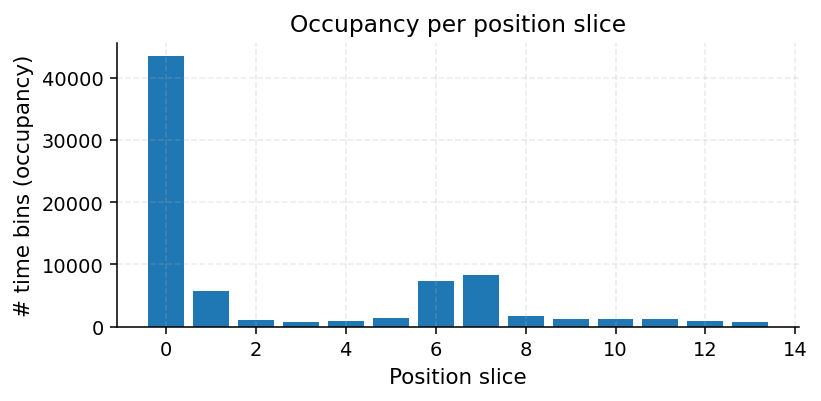

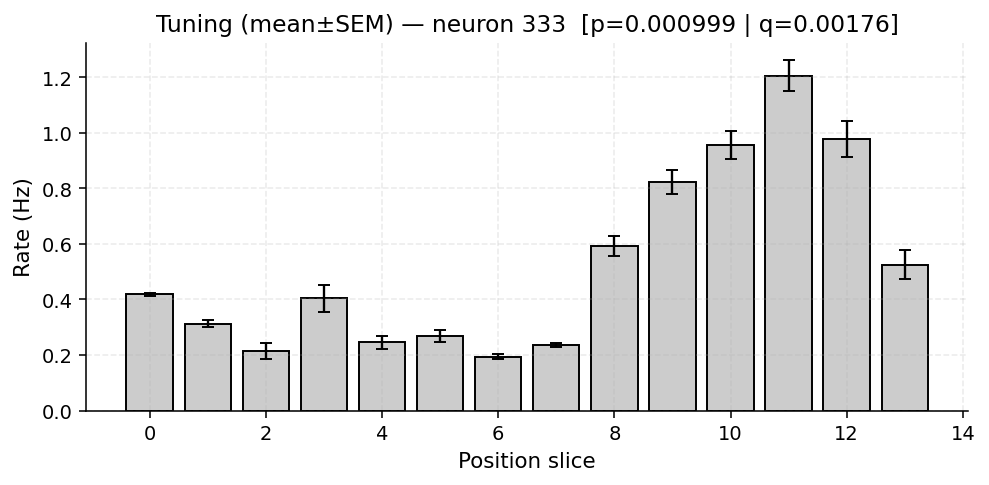

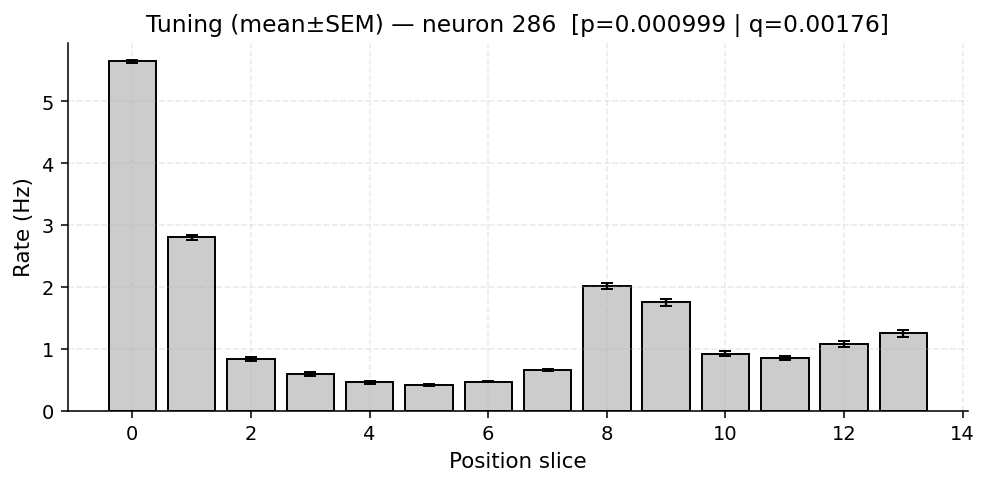

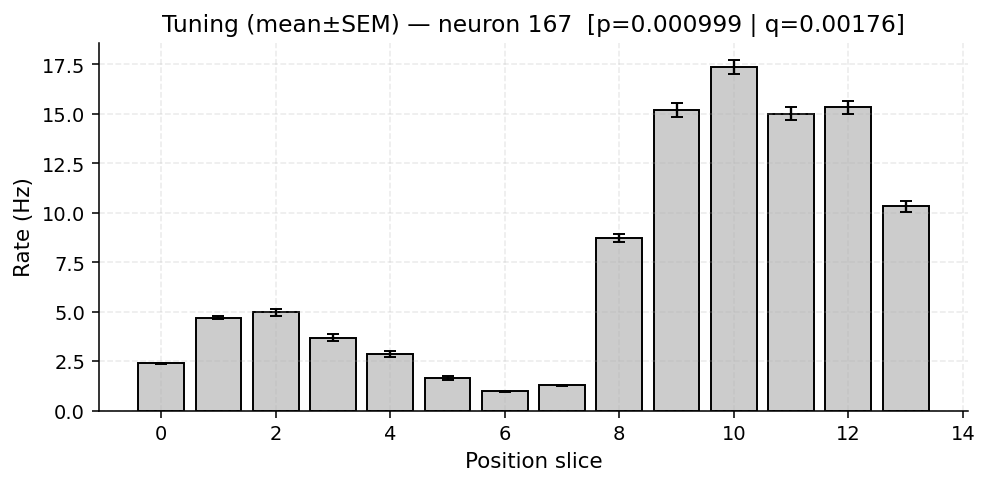

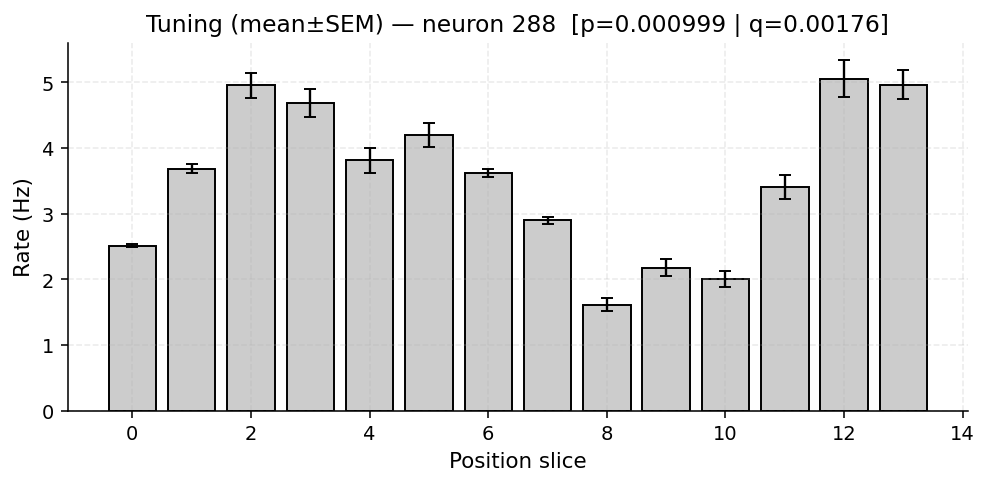

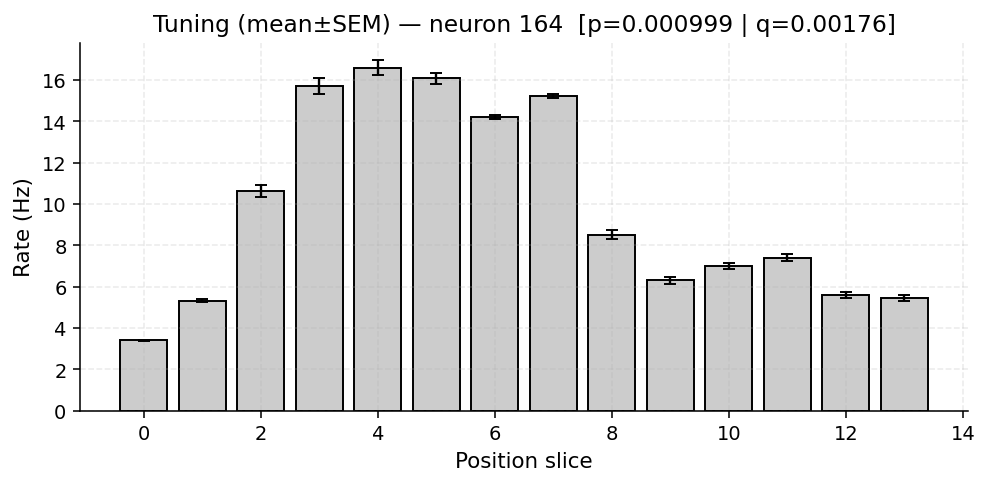

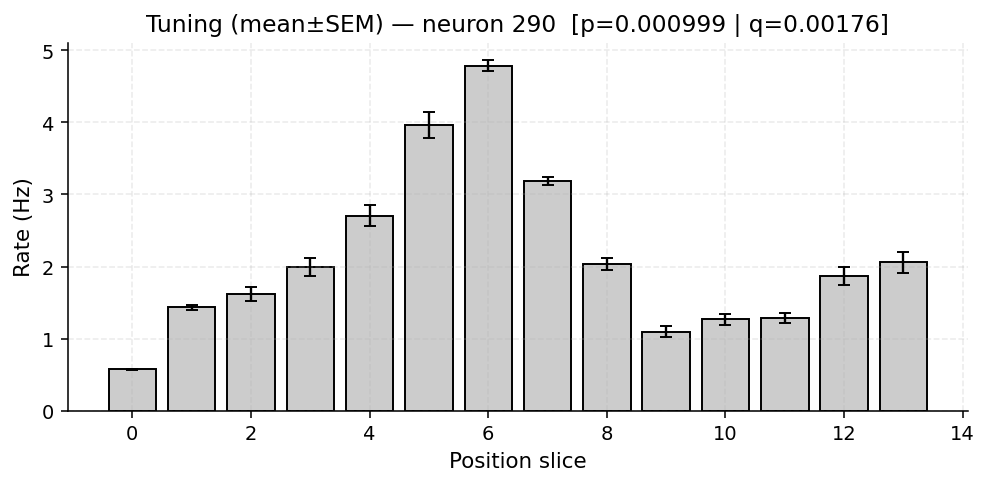

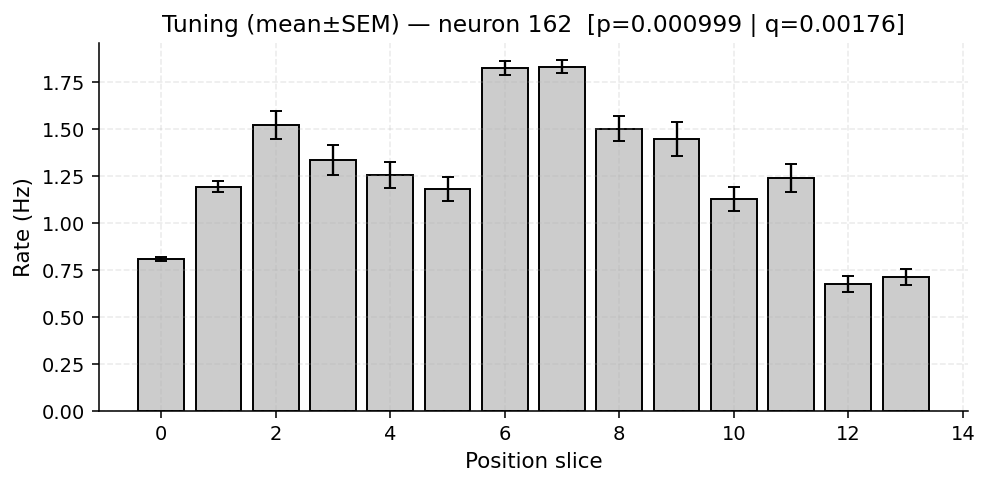

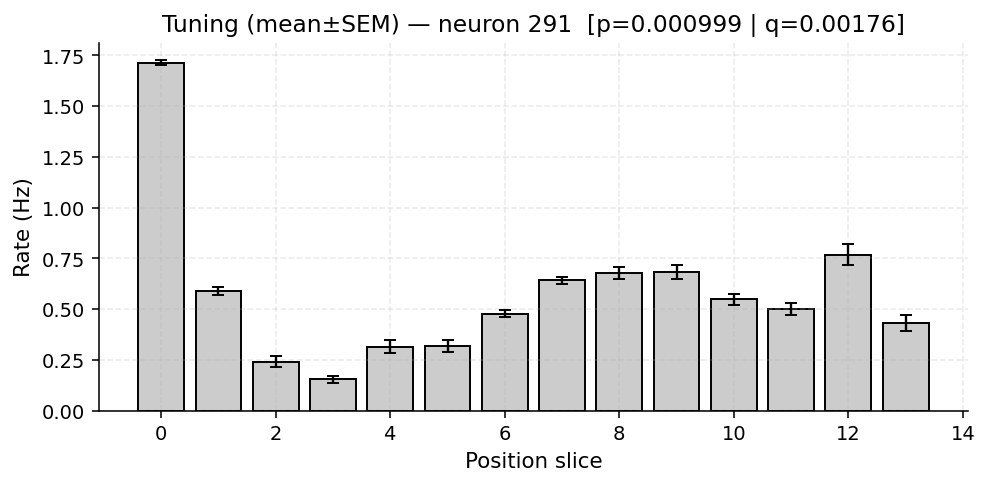

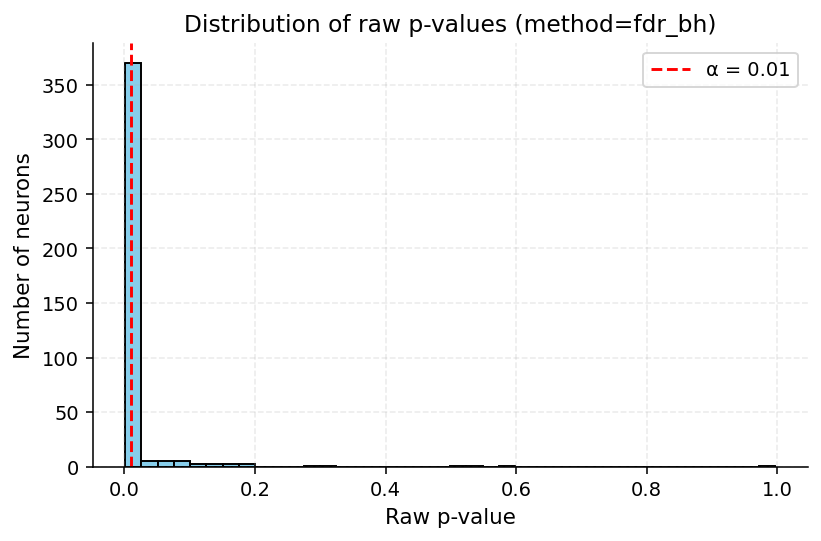

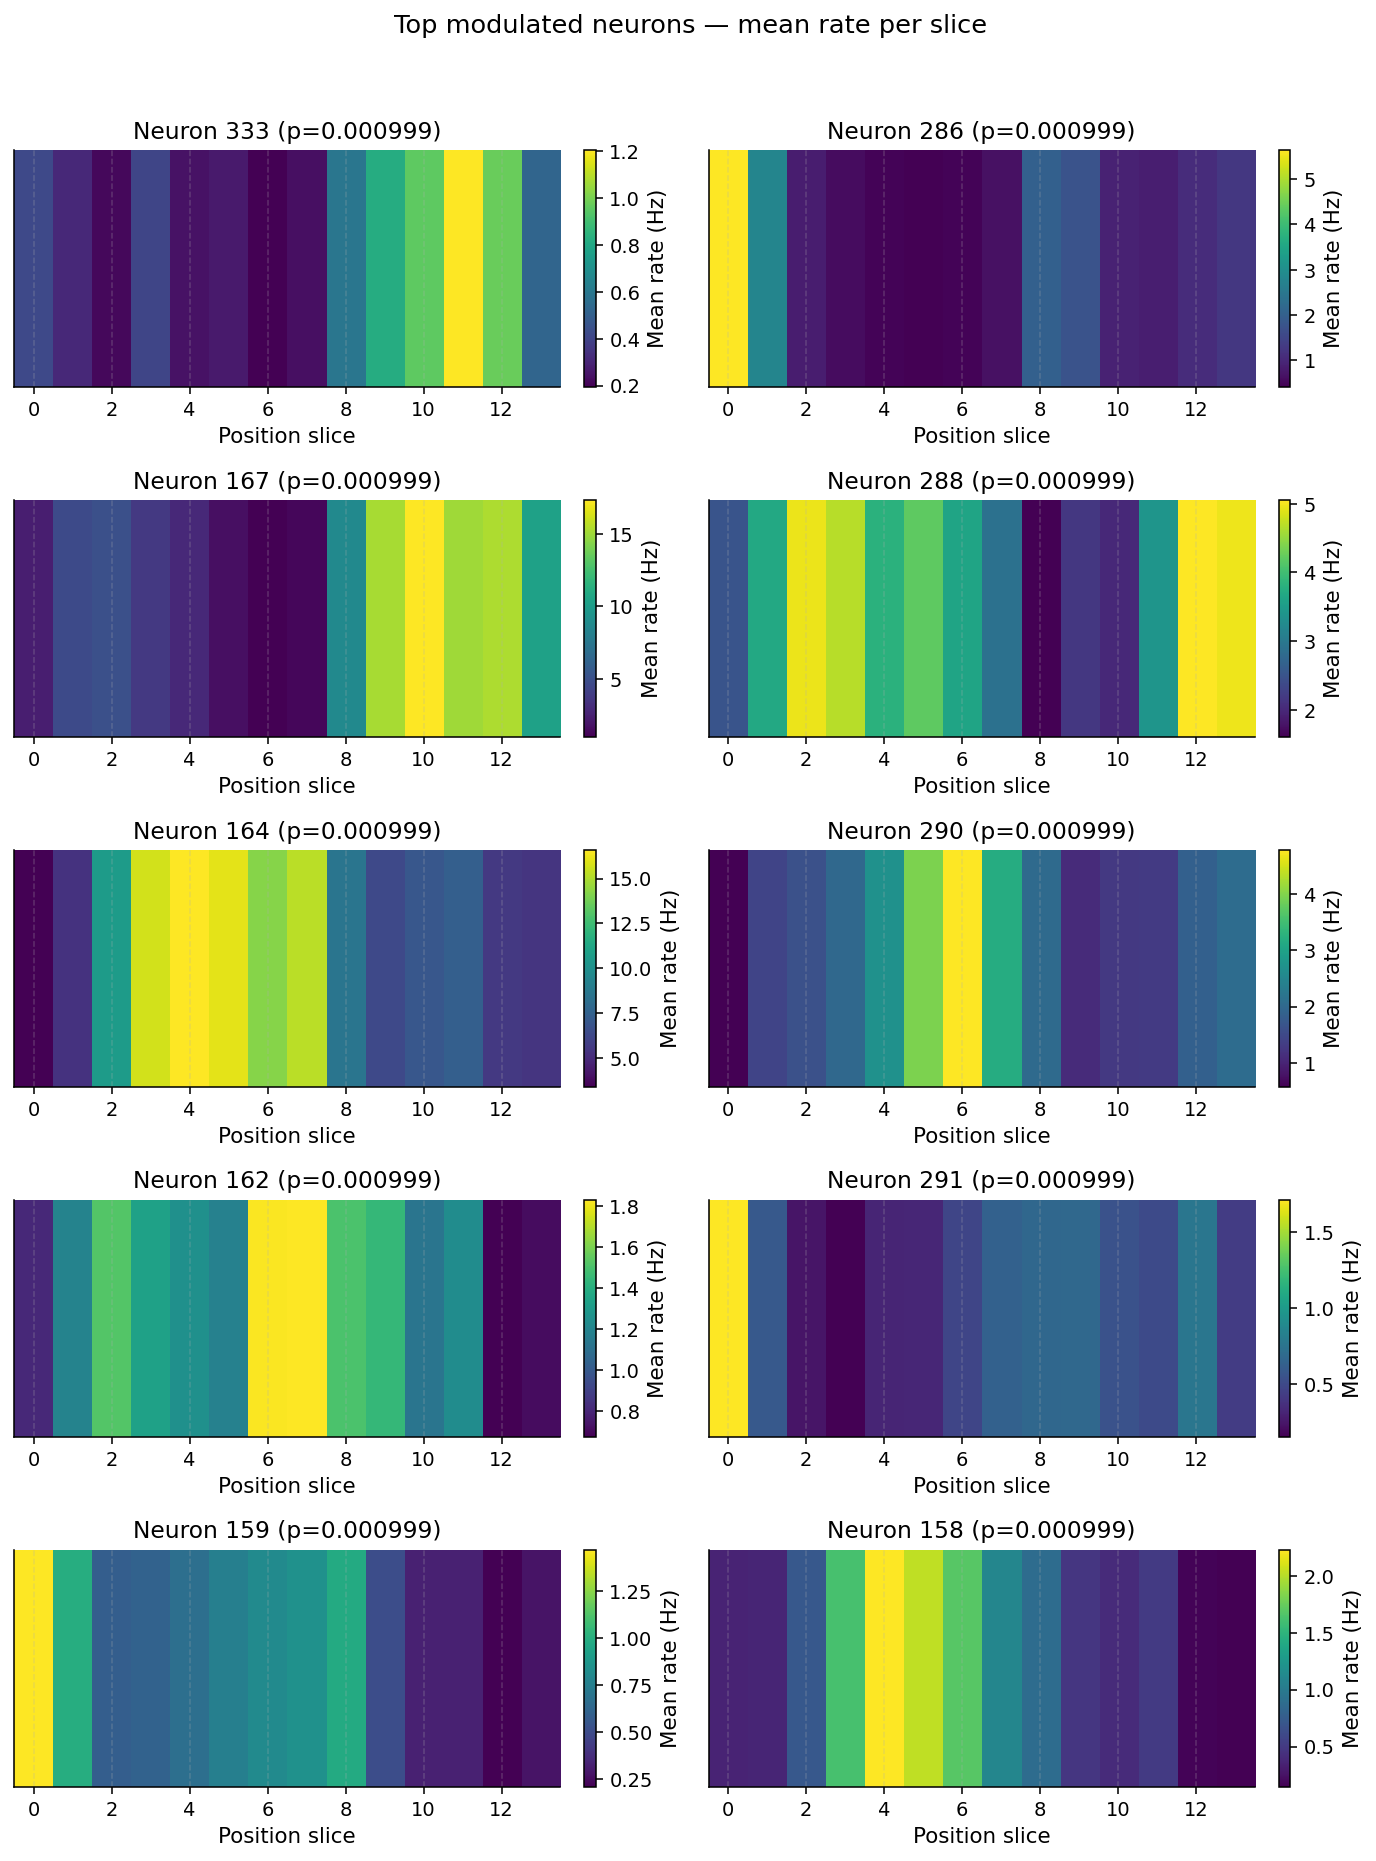

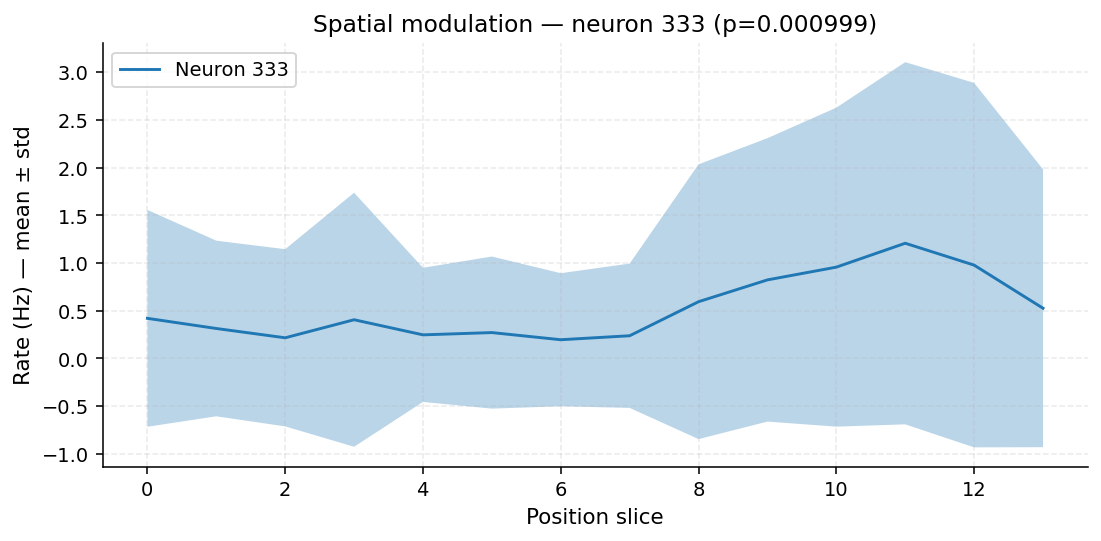

In [812]:
# Example usage: baseline (no speed filter)
results_no_speed = identify_position_modulated_neurons(activity_matrix=mat_100pp_spikefiltered, bin_size_ms=100, lwhl=lwhl, 
     sampling_rate_wheel=39.0625, n_slices=14, min_spikes=100, alpha=0.01, method='fdr_bh', use_nonparametric=False, verbose=True)

figs0 = plot_position_modulation_results(results_no_speed, top_k=10, pval_hist_bins=40)

[INFO] Speed filter: threshold=5 → kept 21.0% bins
[INFO] Neurons kept: 381 / 399 (≥ 100 spikes)


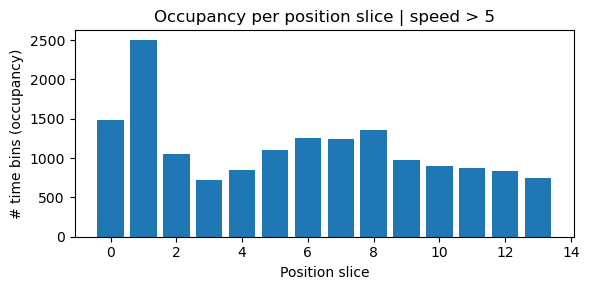

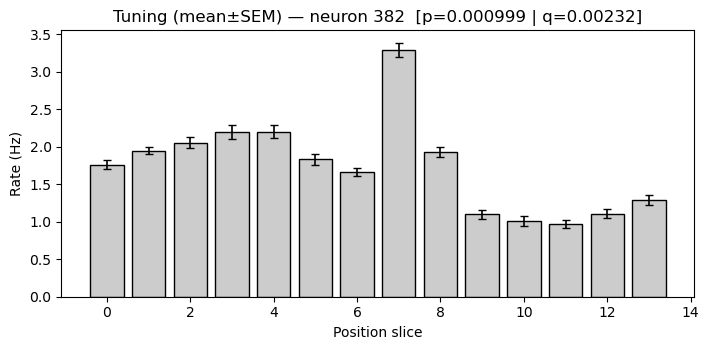

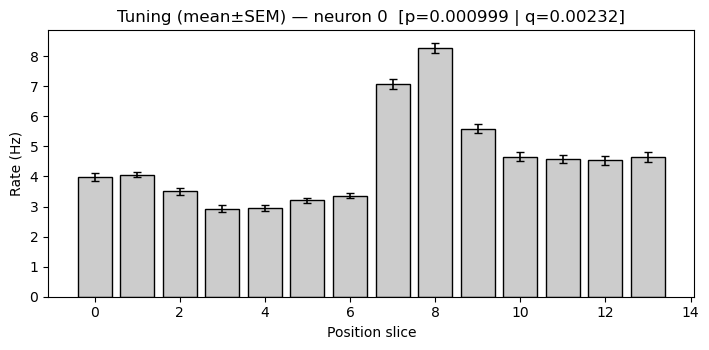

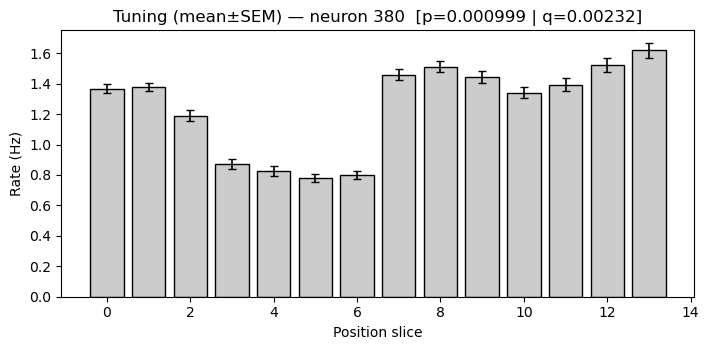

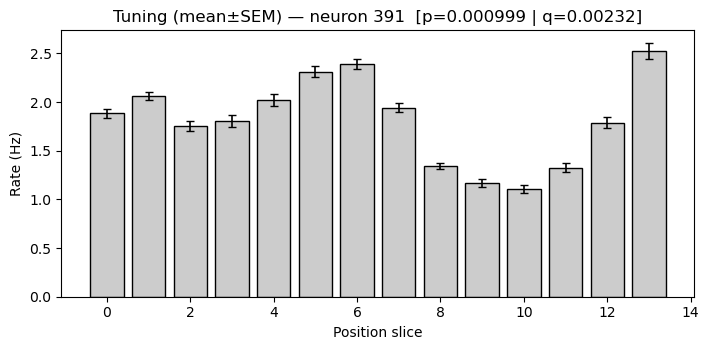

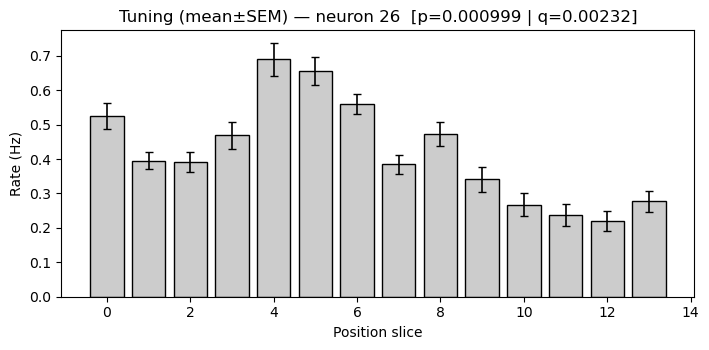

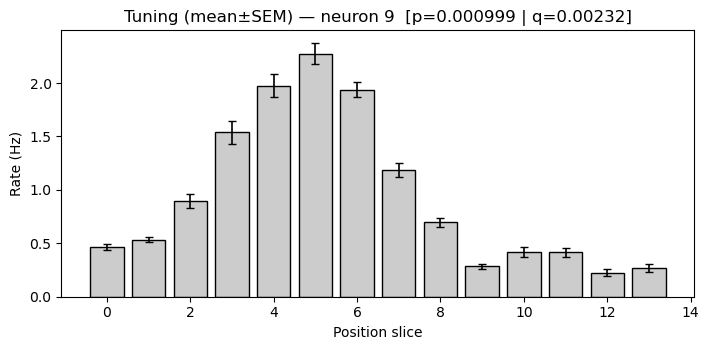

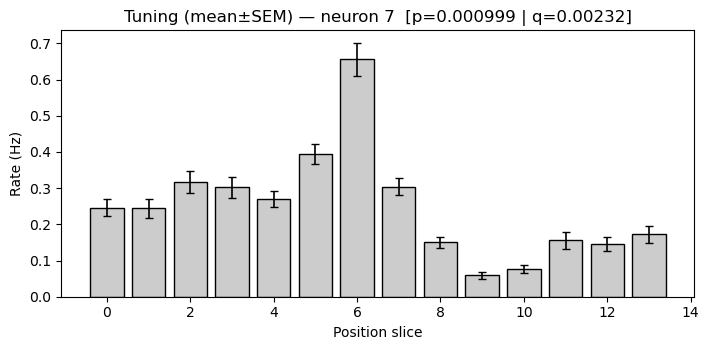

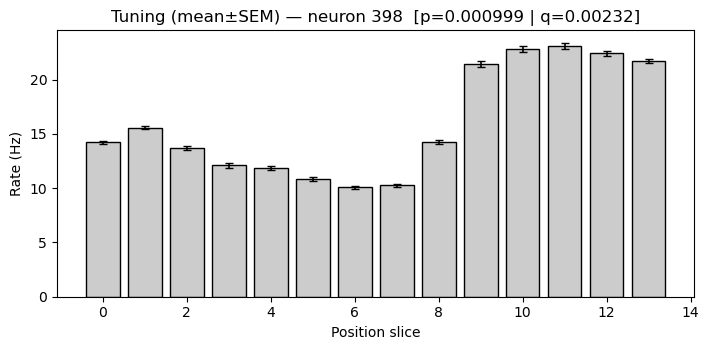

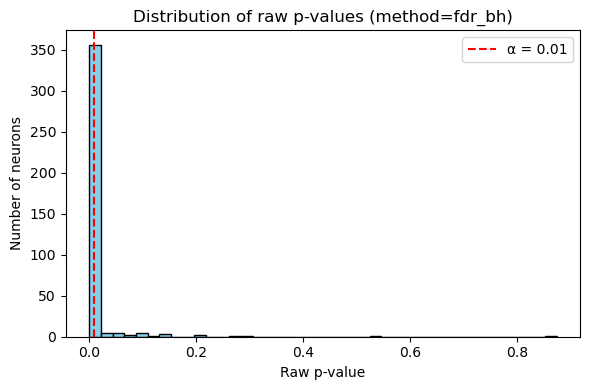

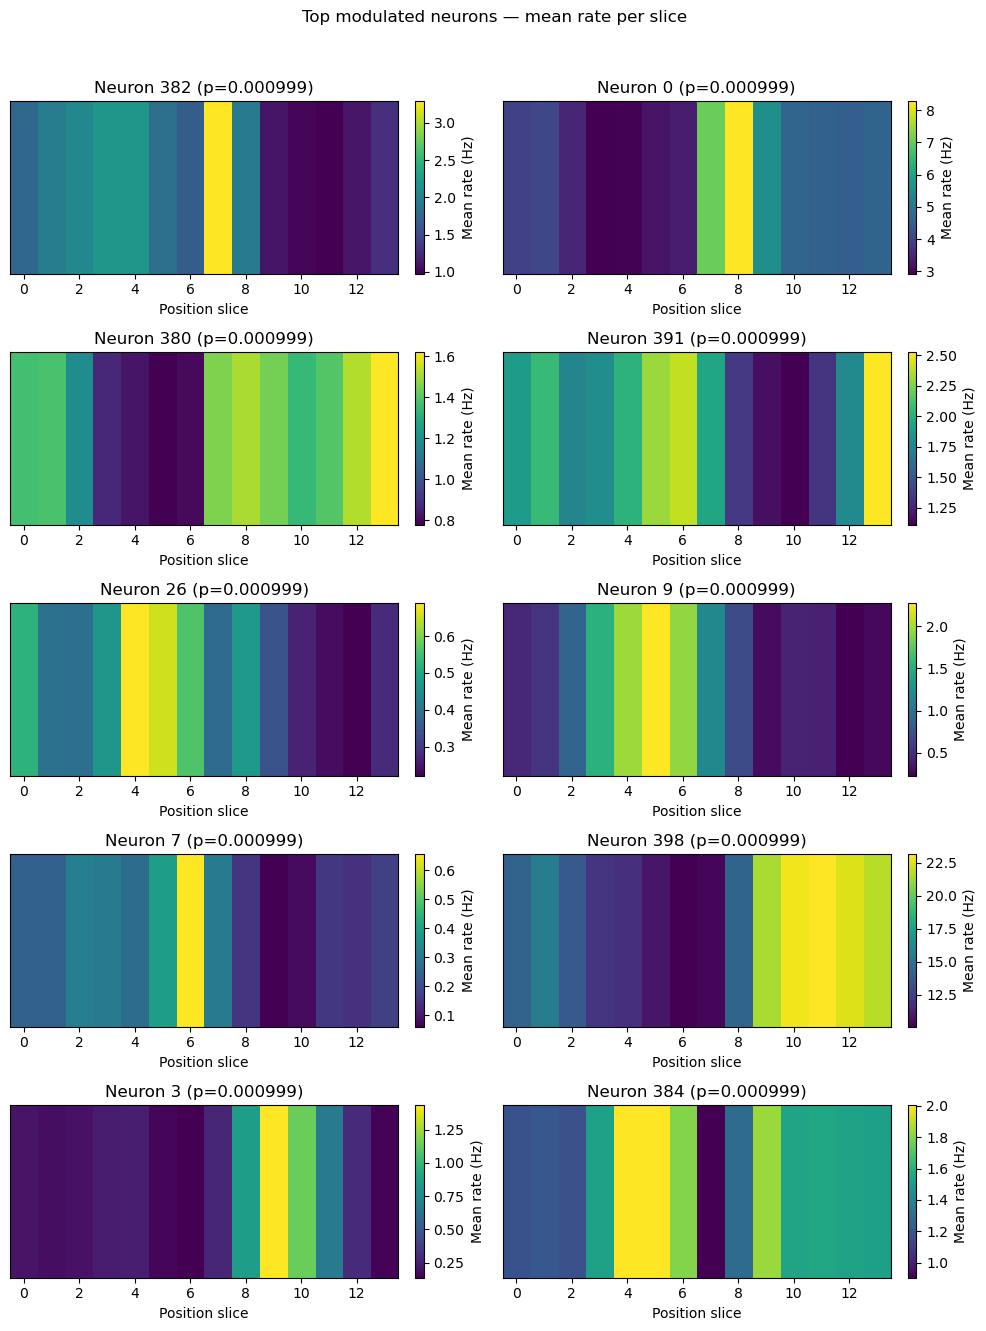

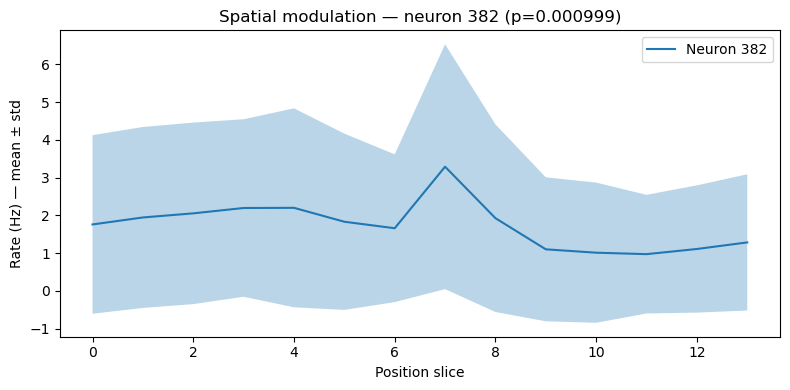

In [7]:
# Example usage: with speed filter
results_speed = identify_position_modulated_neurons(activity_matrix=mat_100pp_spikefiltered,
    bin_size_ms=100, lwhl=lwhl, sampling_rate_wheel=39.0625, n_slices=14, min_spikes=100, alpha=0.01, method='fdr_bh', use_nonparametric=False,
    verbose=True, speed=speed, speed_threshold=5)

figs1 = plot_position_modulation_results(results_speed, top_k=10, pval_hist_bins=40)

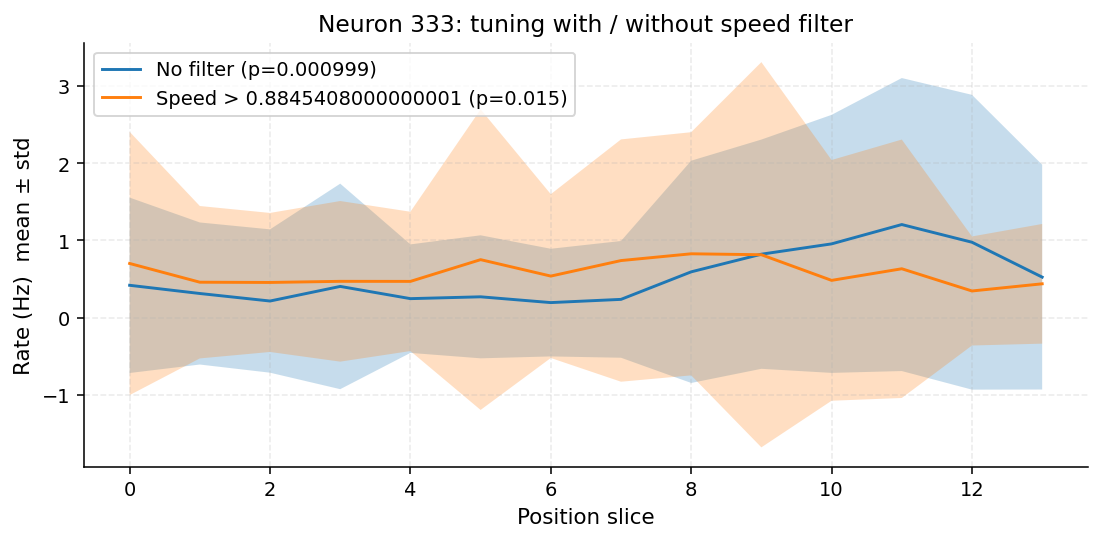

In [813]:
# Visual overlay for the SAME neuron across conditions
#    - pick a neuron that is significant at least in one condition

# Example: choose the best (lowest p) neuron from the no-speed condition
best_neuron = next((idx for idx in results_no_speed['order_by_p']
                    if np.isfinite(results_no_speed['p_raw'][idx])), None)

if best_neuron is not None:
    plot_compare_tuning_for_neuron(results_no_speed, results_speed, neuron_id=best_neuron, label_a="No filter", label_b=f"Speed > {speed_thr:6}")